# COMP 3610 - PROJECT

| UWI ID   | NAME    |
| -------- | ------- |
| `816031687` |  `RAUL ALI`   |
| `816030501` |  `JOSIAH JOEL`   |
| `816030814` |  `DAYANAND MOONOO`   |
| `816031173` |  `ZACHARY RAMPERSAD`   |

NOTES:
- Using K-Folds to validate classification metrics scores
- Expected Cleaning Time = 1:30 min

## IMPORT / READ DATA

In [36]:
# Dataframe / Visualization Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Text Cleaning Imports
import re
!pip install emoji
import emoji
from bs4 import BeautifulSoup
import string
from string import punctuation
# from itertools import chain

# Vectorization Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics/ Utilities Imports
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split , KFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classification Model Imports
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

# Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

# Word Cloud
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# Initialize
seed_value = 42
k_folds = 5
test_size = 1/k_folds
select_percentile_value = 50

# Import data into a data frame
df=pd.read_csv("text.csv", index_col=0)

# Print the last 5 rows to get a general idea of the dataset
df.tail()

,text,label
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3
416808,i think that after i had spent some time inves...,5


## DATA PRE-PROCESSING / CLEANING

- Removing links from the corpus
- Removing punctuation
- Removing HTML tags
- Removing Emojis
- Covert text to lowercase only
- Removing additional white spaces
- Drop duplicates

In [38]:
def clean_text(text):

    # Remove additional white spaces
    text = ' '.join(text.split())

    # Replace emojis with word representation
    text = emoji.demojize(text, delimiters=("", ""))

    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Convert all text to lowercase
    text.lower()

    return text

In [39]:
# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# Remove duplicate text
df.drop_duplicates(subset='clean_text', keep='first', inplace=True)

In [40]:
# Drop the text feature
text_removed = df.pop('text')

# Extract the clean_text column to be moved
move_cleantext = df.pop('clean_text')

# Insert the labels after the clean_text feature column at position 1
df.insert(0, 'clean_text', move_cleantext )

From the Data Description on Kaggle, these are the perceived tone labels ascribed to the text: <br>
- (0) sadness
- (1) joy
- (2) love
- (3) anger
- (4) fear
- (5) surprise

In [41]:
# Run this code to reinsert a refreshed clean_text column
# df.drop(columns=['clean_text'], inplace=True)
# df.insert(0, 'clean_text', move_cleantext )

In [42]:
# Check the number of text samples in each tone category
df['label'].value_counts()

label
1    135030
0    118511
3     54777
4     43629
2     29468
5     12407
Name: count, dtype: int64

### UNDERSAMPLING

Sample an equal number of all review types using the minority class

In [43]:
# shuffle df before sampling
df = shuffle(df, random_state=seed_value)

# Minority class is Surprise
surp = df[df['label']==5]
print(surp.shape)

(12407, 2)


In [44]:
sad = df[df['label']==0].head(surp.shape[0])
joy = df[df['label']==1].head(surp.shape[0])
love = df[df['label']==2].head(surp.shape[0])
angr = df[df['label']==3].head(surp.shape[0])
fear = df[df['label']==4].head(surp.shape[0])

### Common Word Extraction using WordClouds

In [45]:
def print_cloud(data):
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(data)
    return wordcloud

There are 1173290 words in category 0.


There are 1225595 words in category 1.
There are 1302690 words in category 2.
There are 1200728 words in category 3.
There are 1219214 words in category 4.
There are 1256769 words in category 5.


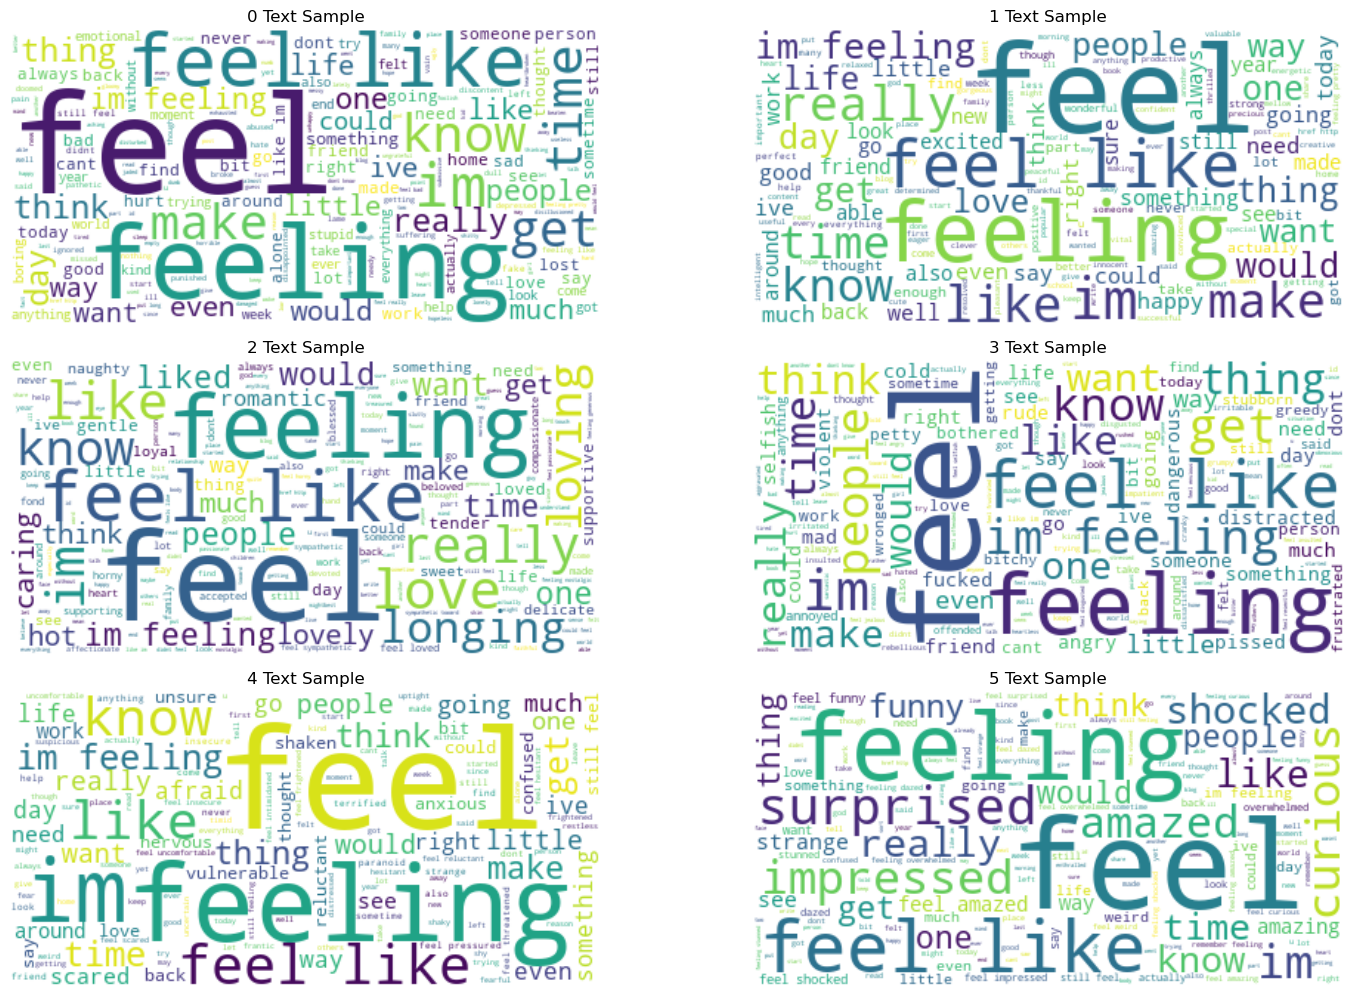

In [46]:
i=1
plt.figure(figsize=(15,20))

arr = [sad, joy, love, angr, fear, surp]

for item in arr:
      item_text = ' '.join(item['clean_text'])
      print ("There are {} words in category {}.".format(len(item_text), i-1))
      wordcloud = print_cloud(item_text)

      plt.subplot(6, 2, i)
      plt.imshow(wordcloud , interpolation='bilinear')
      plt.title('{} Text Sample'.format(i-1))
      plt.axis('off')
      i+=1

plt.tight_layout()
plt.show()

Observe that the words: 'feeling' and 'feel' are common amongst all classes to around the same extent. <br>
Removing common words amongst classes to reduce noise in prediction.

In [47]:
words_to_remove = ['feeling', 'feel', 'like', 'really']

# Function to remove specified words from a text
def remove_words(text):
    for word in words_to_remove:
        text = text.replace(word, '')
    return text

# Apply the function to the 'clean_text' column
df['clean_text'] = df['clean_text'].apply(remove_words)

Resample from the cleaned df

In [48]:
# Sample a equal number of all review types using the minority class
surp = df[df['label']==5]
sad = df[df['label']==0].head(surp.shape[0])
joy = df[df['label']==1].head(surp.shape[0])
love = df[df['label']==2].head(surp.shape[0])
angr = df[df['label']==3].head(surp.shape[0])
fear = df[df['label']==4].head(surp.shape[0])

In [49]:
# Concat all Samples into one df
df_sample = pd.concat([sad,joy,love,angr,fear,surp])

# Shuffle sample df
df_sample = shuffle(df_sample , random_state=seed_value)

# Assign the clean_text field to X and df.sentiment to y
X = df_sample['clean_text']
y = df_sample['label'].values
print(X.shape)

(74442,)


## PROPOSED SOLUTION

### NEURAL NETWORKS
Multi-layer Perceptron (MLP) is a supervised learning algorithm

In [50]:
# Count Vectorizer
countv = CountVectorizer(stop_words = 'english')

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words = 'english')

# TF-IDF Vectorizer with ngrams
tfidf_n = TfidfVectorizer(ngram_range=(1, 2), stop_words = 'english')

In [51]:
X_c = tfidf.fit_transform(X)

select_percentile = SelectPercentile(score_func=f_classif, percentile=select_percentile_value)
X_transformed = select_percentile.fit_transform(X_c, y)


# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=seed_value)

# Train the MLPClassifier
mlpclf = MLPClassifier(hidden_layer_sizes=(5, 2), activation='relu', max_iter=500, random_state=seed_value)
mlpclf.fit(X_train, y_train)

# Predict labels on the test set
y_pred = mlpclf.predict(X_test)

              precision    recall  f1-score   support

           0       0.75      0.66      0.70      2502
           1       0.78      0.80      0.79      2407
           2       0.82      0.85      0.84      2398
           3       0.85      0.89      0.87      2571
           4       0.84      0.86      0.85      2506
           5       0.84      0.84      0.84      2505

    accuracy                           0.82     14889
   macro avg       0.81      0.82      0.81     14889
weighted avg       0.81      0.82      0.81     14889



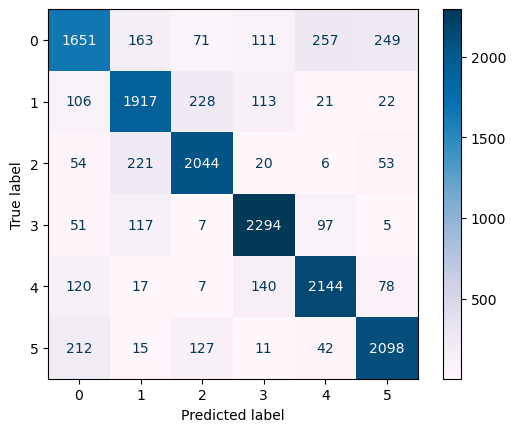

In [52]:
# Generate confusion matrix
confmat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=mlp_classifier.classes_)
disp.plot(values_format="0.0f", cmap='PuBu')

cr = classification_report(y_test, y_pred)
print (cr)

The function `text_fit_perc` has parameters:
- `X`: training set.
- `y`: test set.
- `model`: model type being used.
- `clf_model`: classification algorithm.
- `select_percentile_value`: select percentile to obtain the top features of the corpus data (to reduce runtime).
- `conf_mat_show`: boolean variable that will show Confusion matrix.
- `clf_rep_show`: boolean variable that will show classification reports.

SelectPercentile selects the top features of a dataset which allows us to discard features which are not as important. <br>
To maintain a timely runtime, we will run the models on the top 50 percentile of the corpus. <br>
This will limit the selection to the most important words in our corpus. <br>

In [53]:
def text_fit_perc(X, y, model, clf, select_percentile_value, conf_mat_show= True, clf_rep_show=False):
    X_c = model.fit_transform(X)

    # select percentile for above
    select_percentile = SelectPercentile(score_func=f_classif, percentile=select_percentile_value)
    X_transformed = select_percentile.fit_transform(X_c, y)

    k_fold = KFold(n_splits=k_folds)
    #k_fold.get_n_splits(X_transformed) #get_n_splits  returns the number of splitting iterations
    confmat = np.zeros((6, 6))
    classification_reports =[]

    for train_idx, test_idx in k_fold.split(X_transformed):  #split generates indices to split data into training and test set.
        X_train, X_test = X_transformed[train_idx], X_transformed[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # fit the model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        confmat += confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        classification_reports.append(report)

    if(conf_mat_show):
        print('# features before applying select percentile: {}'.format(X_c.shape[1]))
        print('# features after applying select percentile: {}'.format(X_transformed.shape[1]))

        disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=clf.classes_)
        disp.plot(values_format="0.0f", cmap='PuBu')

    if(clf_rep_show):
        print('\nClassification Reports:')
        for fold_idx, report in enumerate(classification_reports):
            print('Classification Report for fold', fold_idx + 1, ':')
            print(report)

c:\Users\dayan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\dayan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


# features before applying select percentile: 33384
# features after applying select percentile: 16692

Classification Reports:
Classification Report for fold 1 :
              precision    recall  f1-score   support

           0       0.75      0.66      0.71      2455
           1       0.79      0.79      0.79      2446
           2       0.83      0.84      0.84      2522
           3       0.84      0.89      0.86      2494
           4       0.82      0.86      0.84      2519
           5       0.84      0.84      0.84      2453

    accuracy                           0.81     14889
   macro avg       0.81      0.81      0.81     14889
weighted avg       0.81      0.81      0.81     14889

Classification Report for fold 2 :
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      2440
           1       0.75      0.80      0.78      2473
           2       0.82      0.80      0.81      2517
           3       0.86      0.87      0.8

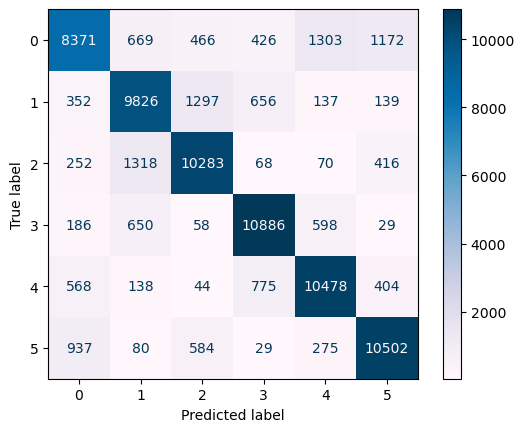

In [54]:
text_fit_perc(X, y, tfidf, mlpclf , 50, True , True)